<a href="https://colab.research.google.com/github/Beniam-Kumela/ekg-classify-ai/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EKG Data Machine Learning Classification

## Exploratory Data Analysis

In [19]:
# Access files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Import necessary python libraries for machine learning, math, and plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [21]:
# Import the training and testing data
train_data_df = pd.read_csv('drive/MyDrive/HackTX-2024/mitbih_train.csv', header=None)
test_data_df = pd.read_csv('drive/MyDrive/HackTX-2024/mitbih_test.csv', header=None)

Here we begin by visualizing a random row of the training dataset.

In [22]:
# ECG Labels
class_labels = {
    0: 'Normal',                          #N
    1: 'Supraventricular Ectopy Beats',   #S
    2: 'Ventricular Ectopy Beats',        #V
    3: 'Fusion Beats',                    #F
    4: 'Unknown Beats'                    #Q
    }

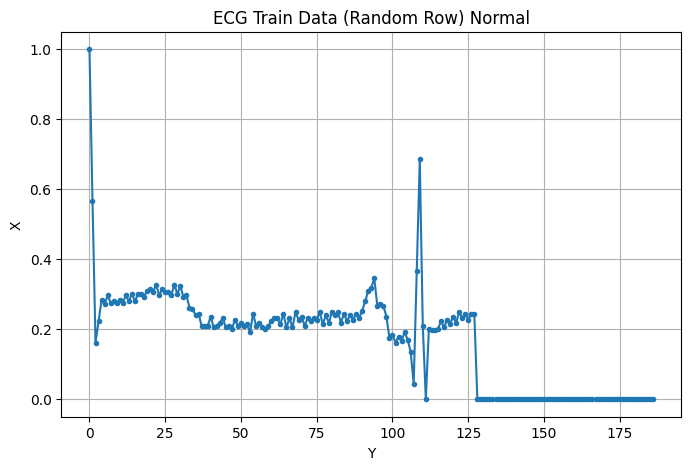

In [23]:
random_row = np.random.choice(train_data_df.index) # Select a random row from the training data set

ecg_row = train_data_df.iloc[random_row, :].values # Extract the data from the random row
ecg_data_row = ecg_row[:-1] # Return all values expect the last element of the array
ecg_class = ecg_row[-1:][0] # Return the first element of the random row data - contains label data
ecg_class = int(ecg_class) # Convert floating point to integer
ecg_class = class_labels[ecg_class]  # Assign data label information to the number

# Plot the graph of the random row data
plt.figure(figsize=(8, 5))
plt.plot(ecg_data_row, marker='.')
plt.title(f'ECG Train Data (Random Row) {str(ecg_class)}')
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

Next, we repeat the visualization for the testing dataset.

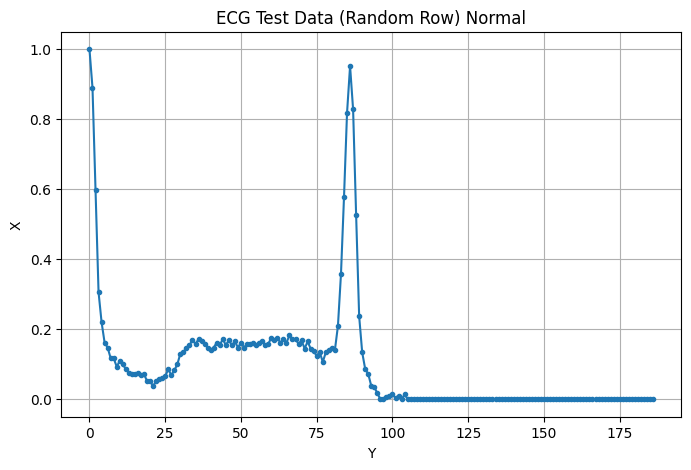

In [24]:
random_row = np.random.choice(test_data_df.index) # Select a random row from the testing data set

ecg_row = test_data_df.iloc[random_row, :].values # Extract the data from the random row
ecg_data_row = ecg_row[:-1] # Return all values expect the last element of the array
ecg_class = ecg_row[-1:][0] # Return the last element of the random row data - contains label data
ecg_class = int(ecg_class) # Convert floating point to integer
ecg_class = class_labels[ecg_class]  # Assign data label information to the number

# Plot the graph of the random row data
plt.figure(figsize=(8, 5))
plt.plot(ecg_data_row, marker='.')
plt.title(f'ECG Test Data (Random Row) {str(ecg_class)}')
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

## Data Loading

Then, we create a function which performs some data processing.

In [29]:
class Dataset_Load(Dataset):

    def __init__(self, csv_file):
        # Read the dataset and store as pandas dataframe (df)
        self.file_df = pd.read_csv(csv_file)

    def __len__(self):
        # Determine the length of the dataset
        return  len(self.file_df)

    def __getitem__(self, idx):
        # Using the index, determine the value
        ecg_data_row = self.file_df.iloc[idx].values # Extract all values in the indexed row
        ecg_data = ecg_data_row[:-1] # Return all values expect the last element of the array
        ecg_data = torch.from_numpy(ecg_data).float() # Convert data to torch tensor

        # One Hot Vector which contains data labeling - NSVFQ
        ecg_class = ecg_data_row[-1:] # Return the last element of the array - contains label data
        ecg_one_hot_vector = np.zeros(5) # There are 5 possible data classifications - NSVFQ
        ecg_one_hot_vector[int(ecg_class[0])] = 1 # According to the label data, mark the classification in the hot vector
        ecg_one_hot_vector = torch.from_numpy(ecg_one_hot_vector) # Convert data to torch tensor

        # First return data tensor with extra dimension - needed for dimensional compatibility with CNNs
        # Second return hot-vector tensor
        return (ecg_data.unsqueeze(0), ecg_one_hot_vector)

Next, we load data in batches using PyTorch.

In [30]:
# Determine optimum batch size through empirical testing, differences summarized below:
# Small size leads to noisy gradient estimates - find global minima but slow convergence
# Large size leads to smooth gradients - faster convergence but overfitting / poor generalization
train_batch_size = 16

# Load training and test data sets using defined class and PyTorch DataLoader to chunk data into batch sizes
train_set = Dataset_Load('drive/MyDrive/HackTX-2024/mitbih_train.csv')
train_dataloader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_set = Dataset_Load('drive/MyDrive/HackTX-2024/mitbih_test.csv')
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

# Test if DataLoader has been implemented correctly
train_dataloader_iter = iter(train_dataloader) # creates an iterator for the
train_features= next(train_dataloader_iter)
print(f"Feature batch shape: {train_features[0].size()}") # ECG data vector - should return torch.Size([16, 1, N]) which is the batch_size, extra dimension added, and number of ECG data points per sample.
print(f"Labels batch shape: {train_features[1].size()}") # Hot vector shape - should return torch.Size([16, 5]) which is the batch_size and amount of labels specified in the class above.

Feature batch shape: torch.Size([16, 1, 187])
Labels batch shape: torch.Size([16, 5])


## Model Construction

We will create and test a CNN function with 5 layers using convolution operations, ReLU, and max pooling.

In [44]:
class EcgClassifier(nn.Module):
    def __init__(self):
        super(EcgClassifier, self).__init__() # Inheritance from PyTorch class nn.Module

        # Use 5 convolutional layers, optimize hyperparameters (kernels, input/output channels, padding) based on trial and error
        # Can calculate output size based on following formula - watch following video: https://www.youtube.com/watch?v=lxk_nmpqI5M
        # Output_size = (Input_size - Kernel_size + 2 * Padding) / Stride (given by comments)
        self.conv1 = nn.Conv1d(1, 12, kernel_size=5, padding=3)  # 187
        self.conv2 = nn.Conv1d(12, 16, kernel_size=5, padding=3)  # 94
        self.conv3 = nn.Conv1d(16, 16, kernel_size=5, padding=3)  # 48
        self.conv4 = nn.Conv1d(16, 8,  kernel_size=5,  padding=3) # 25
        self.conv5 = nn.Conv1d(8, 4,  kernel_size=5,  padding=3) # 13

        # Downscaling data and enhancing features with maxpooling function
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Final Dense Network - return vector of length 5 with predicted labels
        self.fc = nn.Sequential(
          nn.Linear(7*4, 12),
          nn.Sigmoid(),
          nn.Linear(12, 5, bias=False)
        )

        # Define ReLU function
        self.act = nn.ReLU()

    def my_name(self):
      return "ecg_classifier"

    def forward(self, x):

        # First CNN layer
        #print("X", x.shape) # Size of the input data
        x1 = self.conv1(x) # Apply convolution operation - only captures linear relationships
        x1 = self.act(x1) # Apply ReLU function - nonlinear transformation to capture complex relationships, mitigate vanishing gradient problem
        x = self.maxpool(x1) # Apply maxpooling to enhance features and reduce image size as explained in this video: https://www.youtube.com/watch?v=zg_AA3fZpE0&list=PLuhqtP7jdD8CD6rOWy20INGM44kULvrHu&index=5
        #print("D 1", x.shape) # Size of the output data from after CNN layer, comment out when running model

        # Second CNN layer
        x2 = self.conv2(x)
        x2 = self.act(x2)
        x = self.maxpool(x2)
        #print("D 2", x.shape)

        # Third CNN layer
        x3 = self.conv3(x)
        x3 = self.act(x3)
        x = self.maxpool(x3)
        #print("D 3", x.shape)

        # Fourth CNN layer
        x4 = self.conv4(x)
        x4 = self.act(x4)
        x = self.maxpool(x4)
        #print("D 4", x.shape)

        # Fifth CNN layer
        x5 = self.conv5(x)
        x5 = self.act(x5)
        x = self.maxpool(x5)
        #print("D 5", x.shape)

        x = x.view(x.size()[0], -1)

        #print("X ", x.shape)

        # Drop out for training
        #x=self.dropout(x)

        # Apply final dense network
        y =self.fc(x)

        return y

Let's test the array sizes and syntax with a toy model.

In [45]:
model = EcgClassifier()
batch_size = 10
seq_len = 187

test_input = torch.randn(batch_size, 1, seq_len)

result = model(test_input)

print("Result ", result.shape, result)

Result  torch.Size([10, 5]) tensor([[ 0.2262,  0.1495, -0.1581, -0.1299,  0.0470],
        [ 0.2269,  0.1502, -0.1588, -0.1296,  0.0487],
        [ 0.2271,  0.1505, -0.1609, -0.1304,  0.0483],
        [ 0.2266,  0.1503, -0.1597, -0.1296,  0.0494],
        [ 0.2262,  0.1498, -0.1576, -0.1299,  0.0481],
        [ 0.2267,  0.1512, -0.1607, -0.1302,  0.0494],
        [ 0.2272,  0.1509, -0.1601, -0.1301,  0.0487],
        [ 0.2269,  0.1503, -0.1587, -0.1302,  0.0480],
        [ 0.2271,  0.1510, -0.1595, -0.1295,  0.0502],
        [ 0.2264,  0.1504, -0.1599, -0.1297,  0.0504]], grad_fn=<MmBackward0>)


Next, we create a function which feeds in data in batches to update model weights based on assessed gradients.

In [46]:
def train_and_assess_loop(
    model, optimizer,
    train_loader, test_loader,
    epoch_num, loss_fn,
    test_interval=100, print_interval=10
    ):
    """Train and assess AI Model.

    Input:
      model: AI model being used - in this case, CNN or EcgClassifier()
      optimizer: optimizer being used - taken from PyTorch optim library
      train_loader: training data loader
      test_loader: testing data loader
      epoch_num: number of epochs
      loss_fn: Loss function
      test_interval: Test interval
      print_interval: print current epoch interval based on specified number

    Output:
      train_epoch_loss: training epoch loss
      test_epoch_loss: testing epoch loss
    """

    model.train() # PyTorch command setting mode to train
    train_epoch_loss = 0
    test_epoch_loss  = None

    for batch_idx, data in enumerate(train_loader):
      input_data  = data[0] # features
      target_data = data[1] # labels
      output = model(input_data) # Run input data through CNN model created above
      loss =  loss_fn(output, target_data) # Calculate the loss between predictions and actual labels using specified loss function
      loss.backward() # Backpropagation to compute gradients of model weights
      optimizer.step() # Update model weights based on computed gradients
      optimizer.zero_grad() # Reset gradients to 0 for next iteration
      train_epoch_loss += loss.item() # Accumulates epoch loss

    train_epoch_loss = train_epoch_loss/len(train_loader) # Average the epoch_loss dividing the sum by dataset length

    # Print epoch number if happens to be in specified print_interval
    if epoch_num % print_interval == 0:
      print("\nEpoch Num ", epoch_num, "Train epoch Loss ", train_epoch_loss)

    model.eval() # PyTorch command setting mode to evaluate

    # Only run assessments on testing data per test_interval
    if epoch_num % test_interval == 0:
      with torch.no_grad():
        test_epoch_loss  = 0

        for batch_idx, data in enumerate(test_loader):
          input_data  = data[0] # features
          target_data = data[1] # labels
          output = model(input_data) # Run input data through CNN model created above
          loss =  loss_fn(output, target_data) # Calculate loss
          test_epoch_loss +=  loss.item() # Accumulate epoch loss

        test_epoch_loss=test_epoch_loss/len(test_loader) # Average epoch_loss
        print("\nEpoch Num ", epoch_num, "Test epoch Loss ", test_epoch_loss)


    return train_epoch_loss, test_epoch_loss

Then, we create a function to train the model with defined loss function, optimizer, and learning rate using the looping function defined above.

In [47]:
def train(model, epoch_limit=100, test_interval=2, print_interval=2):
  train_epoch_losses = {}
  test_epoch_losses  = {}

  class_weights = torch.tensor([1.0, 10.0, 10.0, 20.0, 80.0], dtype=torch.float32)/121.0 # Normalize wegihts by dividing by sum of individual weights (80+20+10+10+1=121)
  # Cross-Entropy Loss is often used as a loss function for machine learning classification problems: https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning
  loss_fn = nn.CrossEntropyLoss(weight=class_weights)

  print("Adam Optimizer ") # Dynamic
  # Use Adam (adaptive moment estimation) optimizer to update model weights based on calculated gradients from backpropagation
  optimizer = optim.Adam( model.parameters())

  print("Schedule Set Up")
  # Gradually reduce learning rate every epoch by 0.999 using PyTorch function StepLR
  # This acts almost as a dampener so thath model doesn't overshoot the minimum and slowly approaches optimal solution
  scheduler1 = StepLR(optimizer, step_size=1, gamma=0.999)

  # For all epochs calculate train and test epoch loss using function defined before
  for epoch in range(0, epoch_limit):
     train_epoch_loss, test_epoch_loss = train_and_assess_loop(model, optimizer, train_dataloader, test_dataloader, epoch, loss_fn, test_interval=test_interval, print_interval=print_interval)
     train_epoch_losses[epoch] = train_epoch_loss
     if test_epoch_loss is not None:
      test_epoch_losses[epoch]= test_epoch_loss
     scheduler1.step()

     # Save AU Model
     # Depending on result save model or do not save model
     # save_model_checkpt( save_model_path, model  )

  return train_epoch_losses, test_epoch_losses

Finally, we run the model. This takes a while ~23 min on google colab // implement GPU utilization.

In [48]:
train_epoch_losses, test_epoch_losses = train(model, epoch_limit=20, test_interval=2, print_interval=2)

Adam Optimizer 
Schedule Set Up

Epoch Num  0 Train epoch Loss  0.026915163557267523

Epoch Num  0 Test epoch Loss  0.01839351058939481

Epoch Num  2 Train epoch Loss  0.01339493007820216

Epoch Num  2 Test epoch Loss  0.012090313512437398

Epoch Num  4 Train epoch Loss  0.010645464389620779

Epoch Num  4 Test epoch Loss  0.010849556908115609

Epoch Num  6 Train epoch Loss  0.009315445258749

Epoch Num  6 Test epoch Loss  0.009162217454750265

Epoch Num  8 Train epoch Loss  0.008540735277920437

Epoch Num  8 Test epoch Loss  0.009900488403541812

Epoch Num  10 Train epoch Loss  0.008025470823024022

Epoch Num  10 Test epoch Loss  0.009028185183308205

Epoch Num  12 Train epoch Loss  0.007479783430177498

Epoch Num  12 Test epoch Loss  0.007532461641195091

Epoch Num  14 Train epoch Loss  0.007136646753561147

Epoch Num  14 Test epoch Loss  0.0070581276919131205

Epoch Num  16 Train epoch Loss  0.006457819124263892

Epoch Num  16 Test epoch Loss  0.007295137288941725

Epoch Num  18 Trai

## Analyze model results

First, we analyze the minimization of the loss function by plotting train and test epoch loss as a function of epochs.

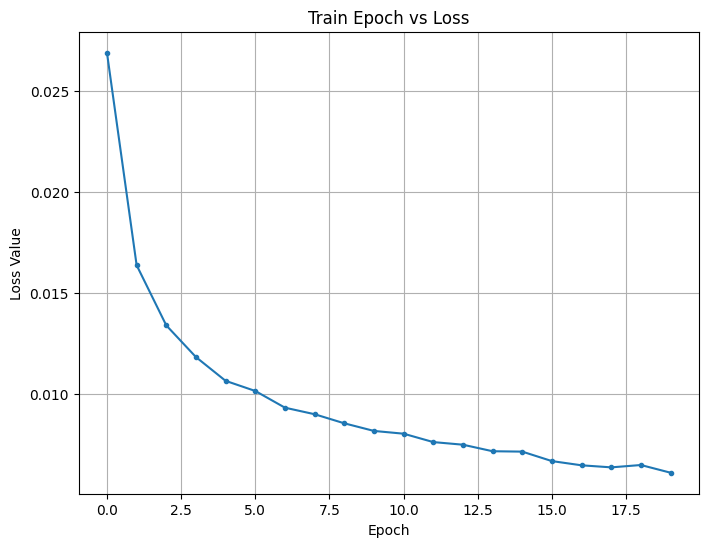

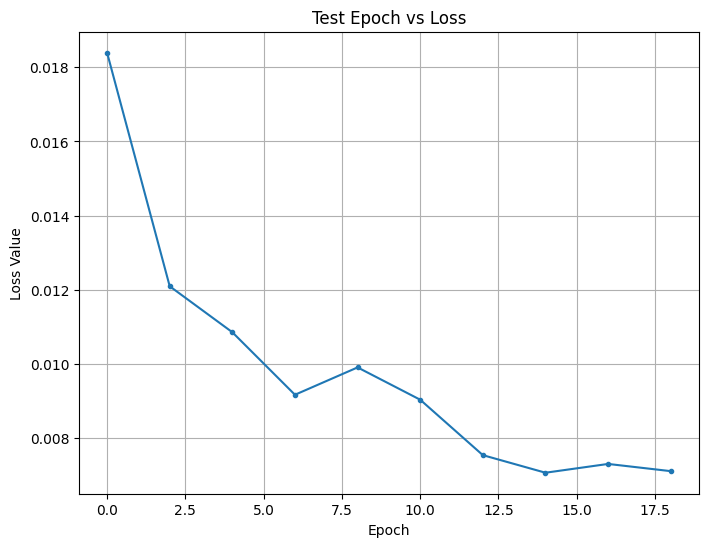

In [51]:
# Extract epochs and loss values
epochs = list(train_epoch_losses.keys())
loss_values = list(train_epoch_losses.values())

# Plot training epoch vs loss values
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='.')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Train Epoch vs Loss')
plt.grid(True)
plt.show()

epochs = list(test_epoch_losses.keys())
loss_values = list(test_epoch_losses.values())

# Plot testing epoch vs loss values
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='.')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Test Epoch vs Loss')
plt.grid(True)
plt.show()

Next, we define 2 functions to post-process results and generate predicted vs actual data.

In [56]:
# Define function to post-process predicted vs target labels
def display_result(model, input_data, target_data):
  model.eval() # PyTorch command setting mode to evaluate
  with torch.no_grad(): # prevent gradient saving so more efficient
    raw_output = model(input_data)
    output = torch.argmax(raw_output) # Return the index of the highest value in raw_output, this should be the predicted label
    predicted_output = output.item() # Convert from torch tensor to python scalar

    # Perform similar operation as above but return the target label to compare to predicted
    target_output = torch.argmax(target_data)
    target_output = target_output.item()

    return predicted_output, target_output

# Define function to compile all results
def collect_results(dataloader):
  prediction_list  = []
  target_list      = []

  for batch_idx, (data, target) in enumerate(dataloader):
    prediction, target = display_result(model, data, target)
    prediction_list.append(prediction)
    target_list.append(target)
  return prediction_list, target_list

Then, we plot the confusion matrix using a heatmap.

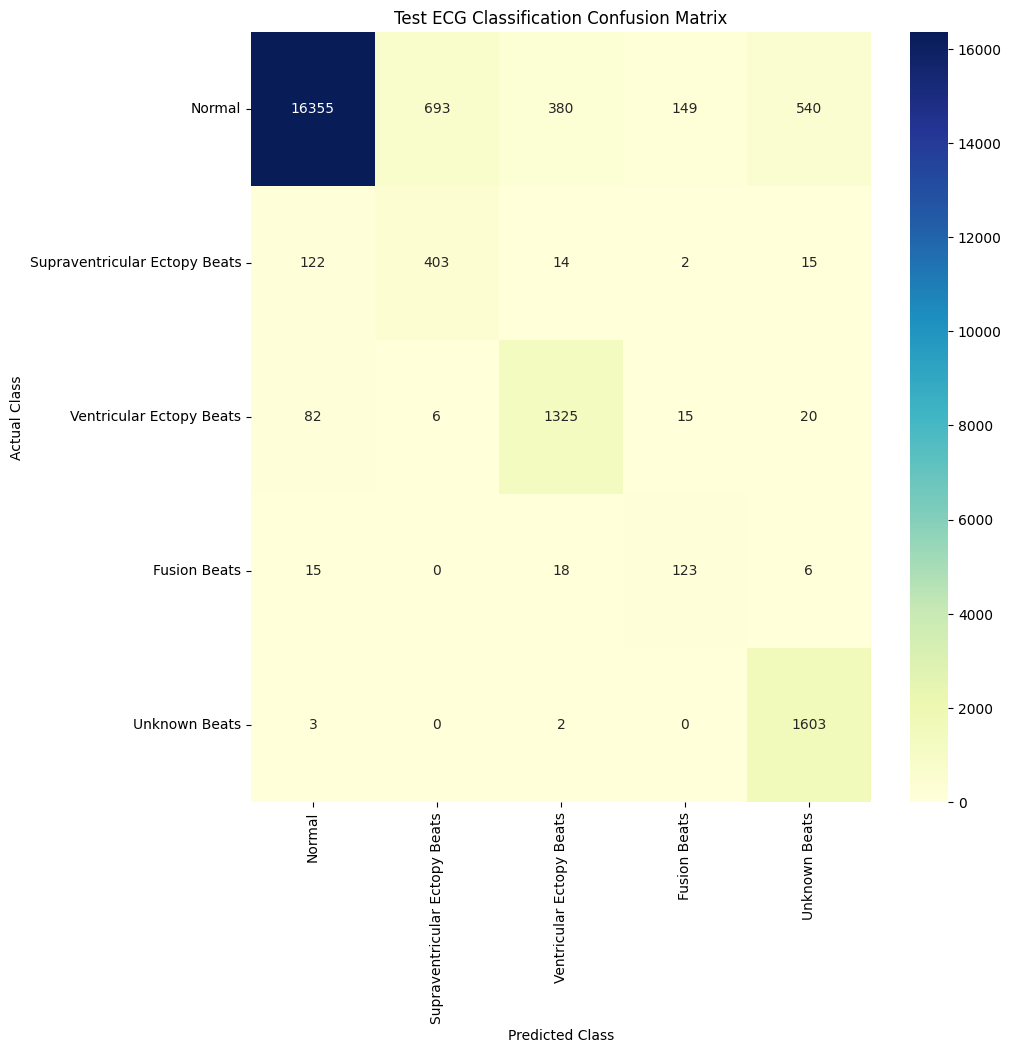

In [58]:
# Compile prediction and target label lists
prediction_list, target_list = collect_results(test_dataloader)

# Plot a confusion matrix of predicted vs target labels
cm = confusion_matrix(target_list, prediction_list)
plt.figure(figsize=(10, 10))
# Serious problem with colors - use more saturation, experiment to highlight diagonal in confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[class_labels[i] for i in range(len(class_labels))],
            yticklabels=[class_labels[i] for i in range(len(class_labels))])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Test ECG Classification Confusion Matrix')
plt.show()

Lastly, we evaluate the relative model predictive accuracy based on this data.

In [59]:
# Calculate class-wise accuracy
class_wise_accuracy = {}
for i, label in class_labels.items():
    correct_predictions = cm[i, i]
    total_actual_instances = cm[i, :].sum()
    accuracy = correct_predictions / total_actual_instances if total_actual_instances > 0 else 0
    class_wise_accuracy[label] = accuracy

# Display class-wise accuracy
print("Class-wise Accuracy:")
for label, accuracy in class_wise_accuracy.items():
    print(f"{label}: {accuracy:.2%}")

# Calculate overall accuracy
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy: {overall_accuracy:.2%}")

Class-wise Accuracy:
Normal: 90.27%
Supraventricular Ectopy Beats: 72.48%
Ventricular Ectopy Beats: 91.51%
Fusion Beats: 75.93%
Unknown Beats: 99.69%

Overall Accuracy: 90.49%


This is just to evaluate what the test data looks like before classification for reporting.

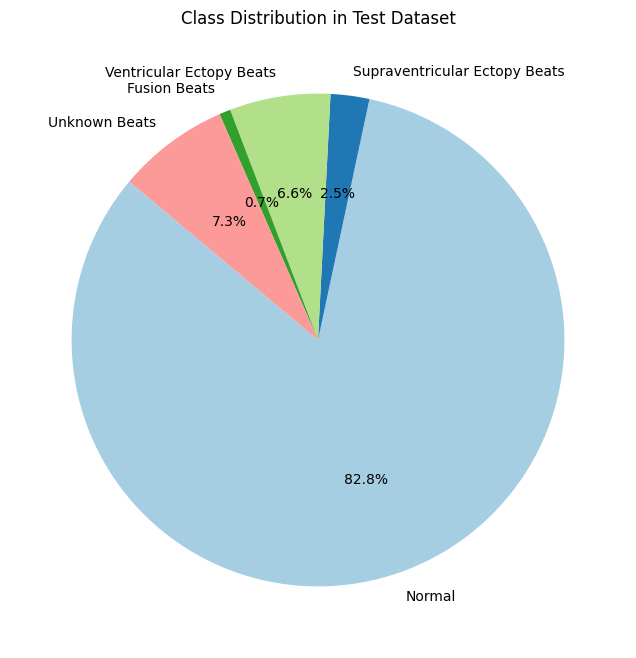

In [62]:
# Count the occurrences of each class in the target list
class_counts = np.bincount(target_list)

# Define labels and corresponding sizes for the pie chart
labels = [class_labels[i] for i in range(len(class_counts))]
sizes = (class_counts / len(target_list)) * 100  # Convert to percentage

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Class Distribution in Test Dataset')
plt.show()